In [1]:
import sys
import os
sys.path.append("../src/")
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet,LinearRegression
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform,binarize
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from sklearn.cross_decomposition import PLSRegression as PLS
import warnings
warnings.simplefilter("ignore")
from multiprocessing import Process,Queue,Pool
import time 
import helper
from multiprocessing import set_start_method
#set_start_method("spawn")
from DecoID.DecoID import flatten
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
import importlib
import helper#import the module here, so that it can be reloaded.
importlib.reload(helper)
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multitest import multipletests
from copy import deepcopy

In [2]:
#load in metadata and peak areas and associate

#read in peak data
datafilename = "../data/QTof-B1-9_pHILIC_HSS_pos-neg_normalized.csv"
data = pd.read_csv(datafilename)

#get area columns
areaCols = data.columns.values[10:]

#get molecule names
mol_names = data["Compound Name"].values

#extract area data and transpose
areaData = data[areaCols].transpose()

#get batch information
batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]

areaData = areaData.to_numpy()
areaData = areaData.astype(np.float)

#get index of blanks
blankSamp = [x for x in range(len(areaCols)) if "Blank" in areaCols[x] and not "equil" in areaCols[x]]
print(len(blankSamp)," blanks")

#get index of qc
qcSamp = [x for x in range(len(areaCols)) if "NIST" in areaCols[x] and not "equil" in areaCols[x] ]
print(len(qcSamp)," qc samples")

#get index of wu350 samples
samp = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
print(len(samp), "research samples")

#load in metadata
metadatafn = "../data/Experiment-Parameters_b1-9.csv"
metadata = pd.read_csv(metadatafn)

#extact sample names for d0_yes samples
metadata_rel = metadata[metadata["day-COVID"] == "d0_Yes"]
print(len(metadata_rel)," d0 Covid+ Samples")

            
#create sample name, ventilator status linkage
vent_dict = {}
metadata_dict = {}
for index,row in metadata_rel.iterrows():
    val = str(row["ICU"])
    sampName = row["Sample General Name"]
    if "es" in val:
        val = 1
    elif "o" in val:
        val = 0
    vent_dict[sampName] = val
    metadata_dict[sampName] = row

print(np.sum(list(vent_dict.values()))," ICU+ samples")
print(len(vent_dict) - np.sum(list(vent_dict.values())),"ICU- samples")

#link vent status to sample in peak data
vent_status = []
metadata_for_samples = []
patient_ids = []

for s in np.array(areaCols)[samp]:
    tmp = s
    if tmp in vent_dict:
        vent_status.append(vent_dict[tmp])
        metadata_for_samples.append(metadata_dict[tmp])
        patient_ids.append(metadata_dict[tmp]["WU-350"])

    else:
        vent_status.append(-1)
        metadata_for_samples.append(-1)
        patient_ids.append(-1)



print("found vent info for",len([x for x in vent_status if x != -1]),"covid_ d0 samples")
samplesOfInterest = [x for x in range(len(vent_status)) if vent_status[x] != -1]
ICU_vals = np.array([x for x in vent_status if x != -1])

patient_ids = np.array(patient_ids)[samplesOfInterest]
#create sample matrix
samp_int = np.log2(areaData[samp][samplesOfInterest])

patient_ICU = {id:stat for id,stat in zip(patient_ids,ICU_vals)}
patient_ind = {id:i for id,i in zip(patient_ids,range(len(patient_ids)))}

var_imp = pd.read_csv("../data/var_importance_final.csv",index_col=0)

vars_of_interest = []
for x in var_imp.index.values:
    index = 0
    for y in mol_names:
        if x == y:
            vars_of_interest.append(index)
            break
        index += 1 
        
samp_int = samp_int[:,vars_of_interest]
mol_names = var_imp["plot-name"].values

print(samp_int.shape)
var_imp

0  blanks
0  qc samples
704 research samples
264  d0 Covid+ Samples
123  ICU+ samples
141 ICU- samples
found vent info for 263 covid_ d0 samples
(263, 25)


,var_imp,plot-name
HSSneg_LPE 18:0@7.653,-0.001013,LPE 18:0
HSSpos_Cer_NS d18:1_16:0_17.788,0.001118,Cer-NS d18:1_16:0
HSSpos_Cer_NS d18:2_16:0_16.67,0.000905,Cer-NS d18:2_16:0
HSSpos_LPC 0:0/16:0_4.715,-0.000702,LPC 0:0/16:0
HSSpos_LPC 0:0/18:0_6.997,-0.001206,LPC 0:0/18:0
HSSpos_LPC 14:0/0:0_3.387,-0.000405,LPC 14:0/0:0
HSSpos_LPC 15:0/0:0_4.164,-0.000155,LPC 15:0/0:0
HSSpos_LPC 16:0/0:0_5.147,-0.000232,LPC 16:0/0:0
HSSpos_LPC 16:1/0:0_3.734,0.000187,LPC 16:1/0:0
HSSpos_LPC 17:0/0:0_6.28,-0.000472,LPC 17:0/0:0


In [3]:
measurement_data = pd.read_csv("../data/PMN_CRP_d-dimer_CO2_Comorbidities_updated.csv",index_col=0)
measurement_data

,CRP,D-dimer,Neutrophil %,CO2,Hypoxia,Diabetes,Acute renal failure,Chronic Kidney Disease,Cancer,Critically high/low arterial pH,BMI,Age,Smoker,High/low Arterial pH,Acute respiratory failure,Neutrophil absolute
Patient,,,,,,,,,,,,,,,,
WU350-004,80.6,-1,73.8,28,1,1,0,0,0,1,49.0,62.4,0,1,1,3.3
WU350-005,265.6,-1,83.5,20,0,1,0,0,0,0,19.6,65.3,1,1,0,8.0
WU350-006,273.3,7279,64.5,27,1,1,0,1,1,0,29.1,74.7,-1,1,1,2.0
WU350-007,292.4,727,84.2,28,1,0,0,0,0,1,24.7,55.5,-1,1,1,10.4
WU350-008,-1.0,-1,56.8,25,0,0,0,0,0,0,46.5,38.0,-1,0,0,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WU350-394,185.5,2442,81.8,20,0,1,0,1,0,1,35.0,64.9,0,1,0,8.6
WU350-395,-1.0,-1,82.1,25,0,0,0,0,0,0,20.0,20.9,1,0,0,12.6
WU350-397,-1.0,1014,93.3,25,0,1,0,0,0,1,44.6,53.1,-1,1,0,7.6


In [4]:
to_drop = []
for index,row in measurement_data.iterrows():
    if index not in patient_ids:
        to_drop.append(index)
measurement_data = measurement_data.drop(to_drop)

df = measurement_data


In [5]:
correlative_df = {mol:{fact:-1 for fact in list(measurement_data.columns.values)} for mol in mol_names}
pval_df = {mol:{fact:-1 for fact in list(measurement_data.columns.values)} for mol in mol_names}
icu2Include = [1,0]
for col in measurement_data.columns.values:
    for met in range(len(mol_names)):

        plot_df = {}
        val = samp_int[:,met]
        index = 0
        for x,pat in zip(val,patient_ids):
            if pat in list(df.index.values) and patient_ICU[pat] in icu2Include:
                comorb = df.at[pat,col]
                if not pd.isna(comorb):
                    if type(comorb) == type(""):
                        comorb = comorb.replace("<","").replace(">","")
                    if float(comorb) > -.5:
                        plot_df[index] = {col:float(comorb),"Intensity":x}
                        index += 1

        plot_df = pd.DataFrame.from_dict(plot_df,orient="index")
        r,p = stats.pearsonr(plot_df[col].values,plot_df["Intensity"].values)
        correlative_df[mol_names[met]][col] = r
        pval_df[mol_names[met]][col] = p



            





In [6]:
correlative_df = pd.DataFrame.from_dict(correlative_df,orient="index")
pval_df = pd.DataFrame.from_dict(pval_df,orient="index")


In [7]:
mask_df = deepcopy(pval_df)
ind = []
pvals = []
alpha = 0.05
for index,row in pval_df.iterrows():
    for col in pval_df.columns.values:
        ind.append((index,col))
        pvals.append(pval_df.at[index,col])

reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
for i,p in zip(ind,pvals_corr):
    if p < alpha:
        mask_df.at[i[0],i[1]] = 0
    else:
        mask_df.at[i[0],i[1]] = 1
        
def name_conv(name):
    return name.replace(name.split("_")[0],"")

<Figure size 3000x2000 with 0 Axes>

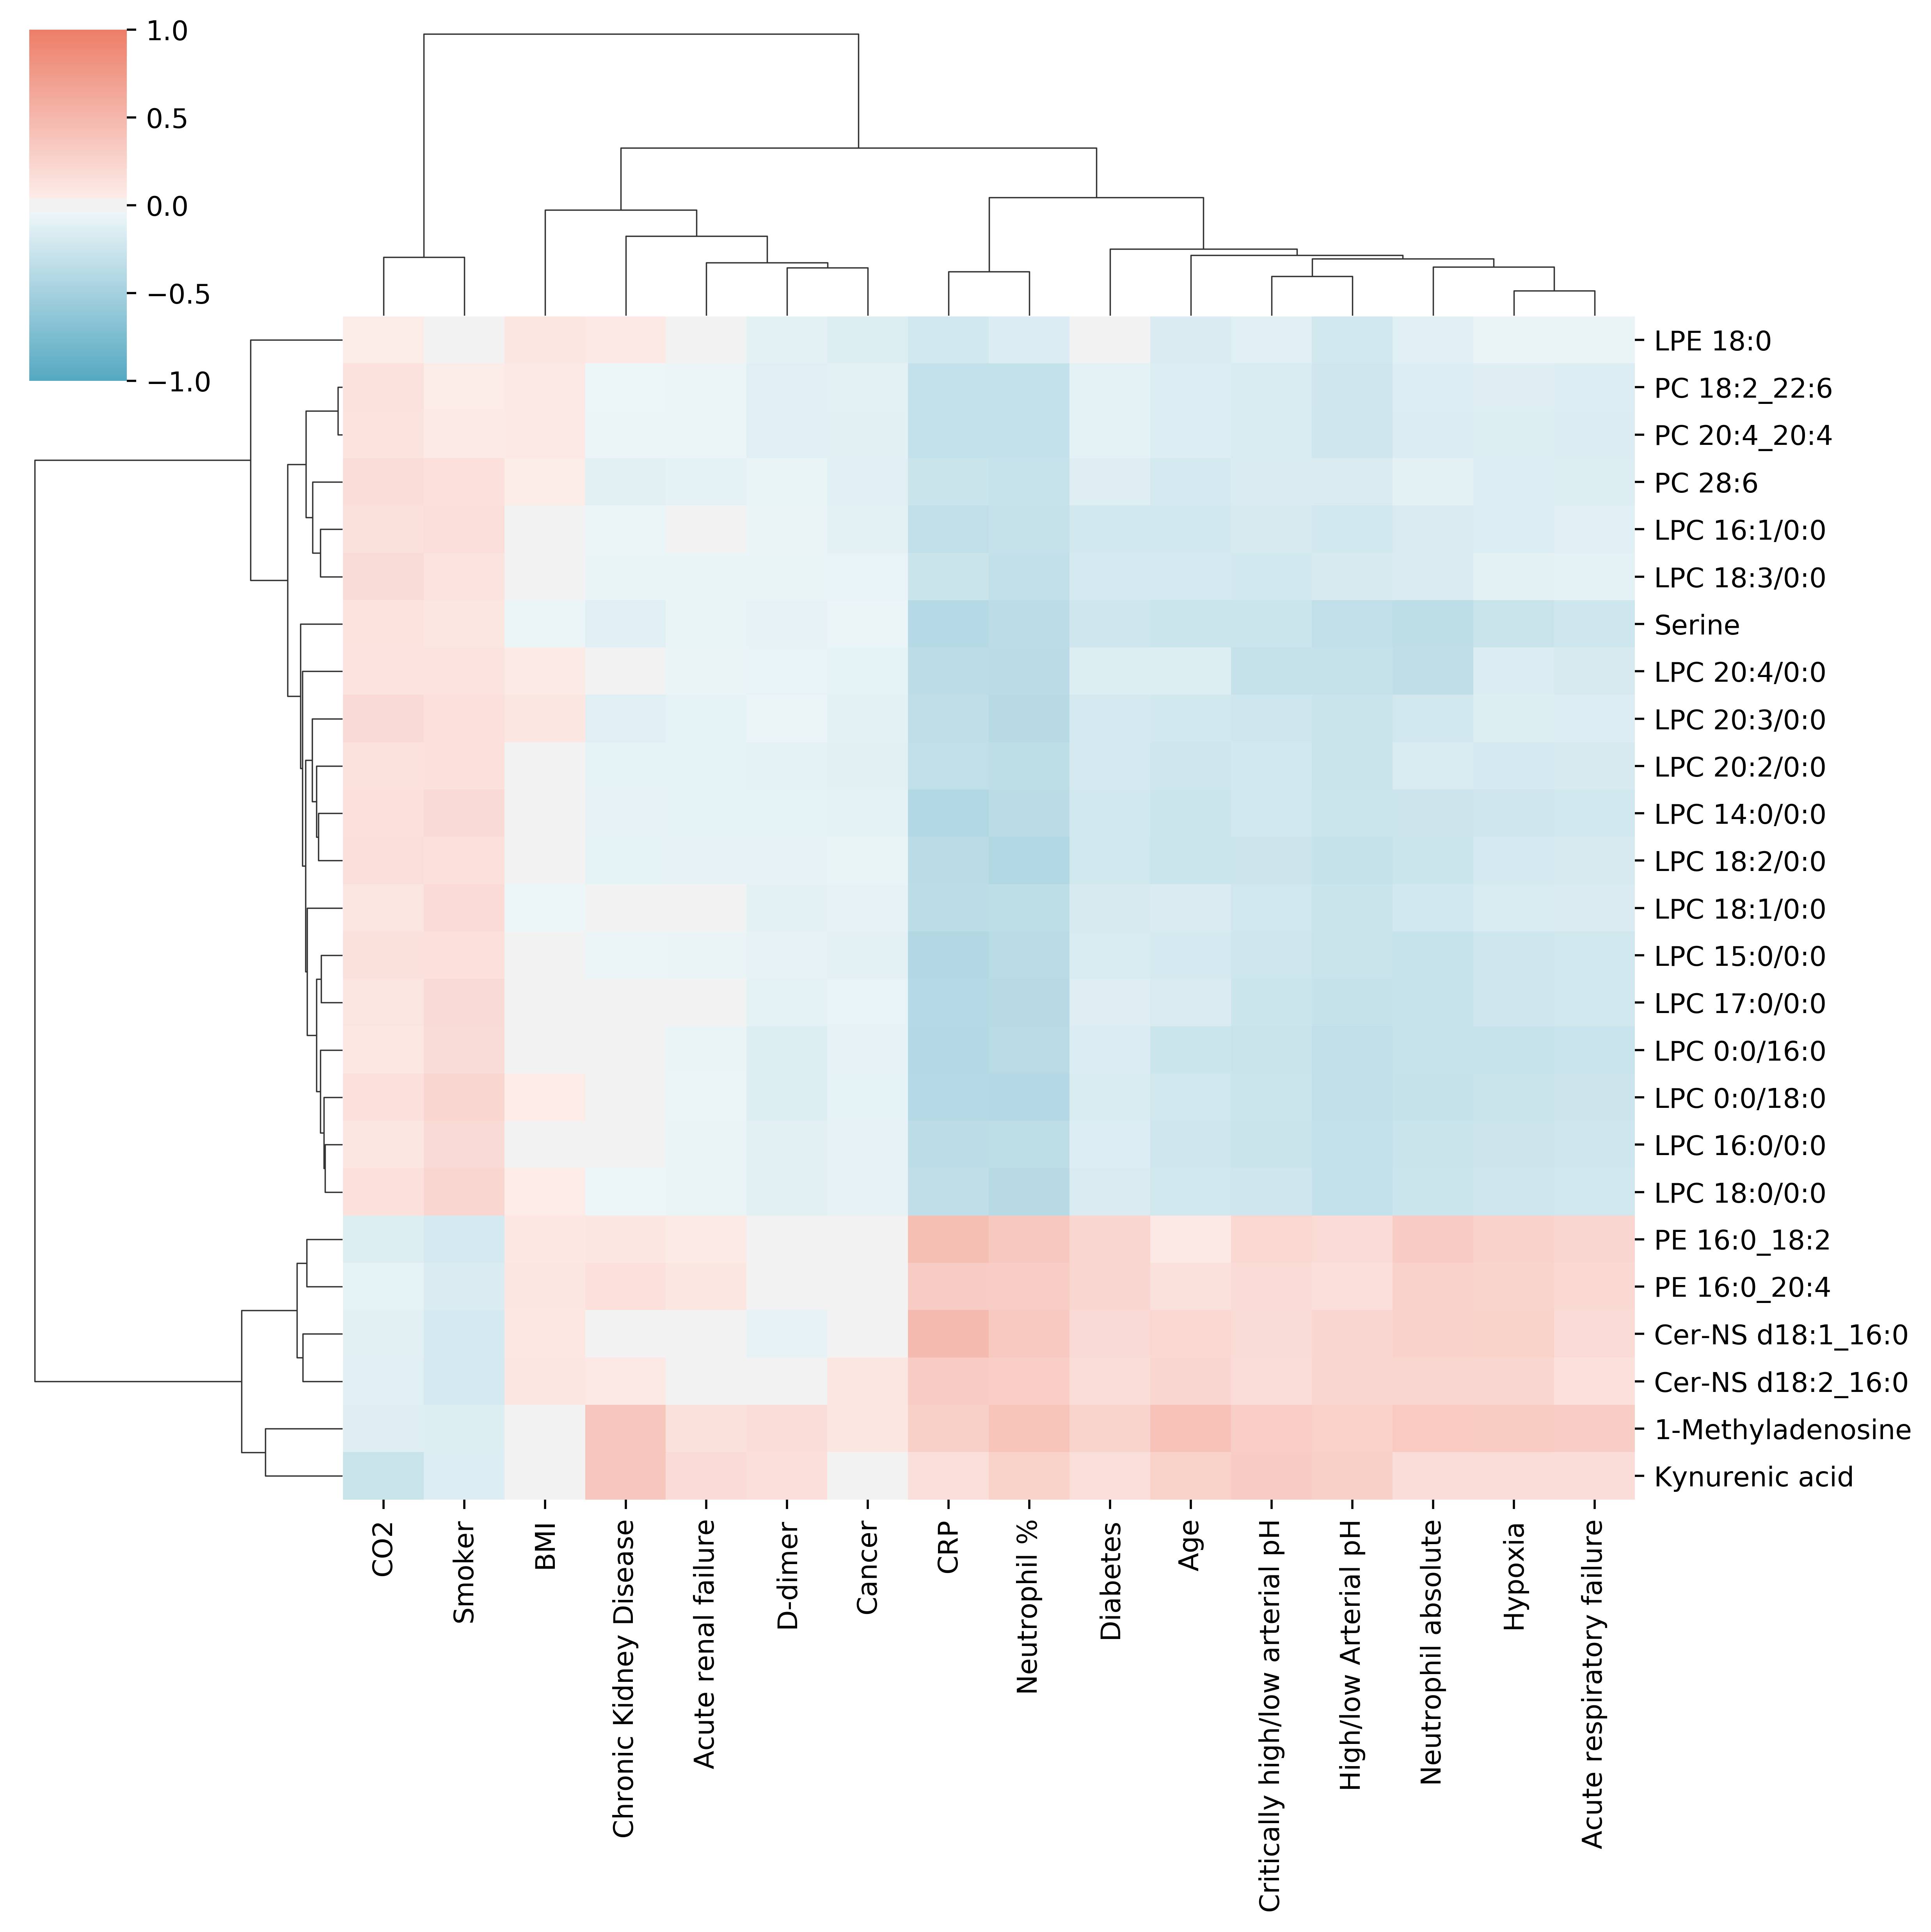

<Figure size 3000x2000 with 0 Axes>

In [8]:

sb.clustermap(correlative_df,vmax=1.0,vmin=-1,cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True))

plt.figure()

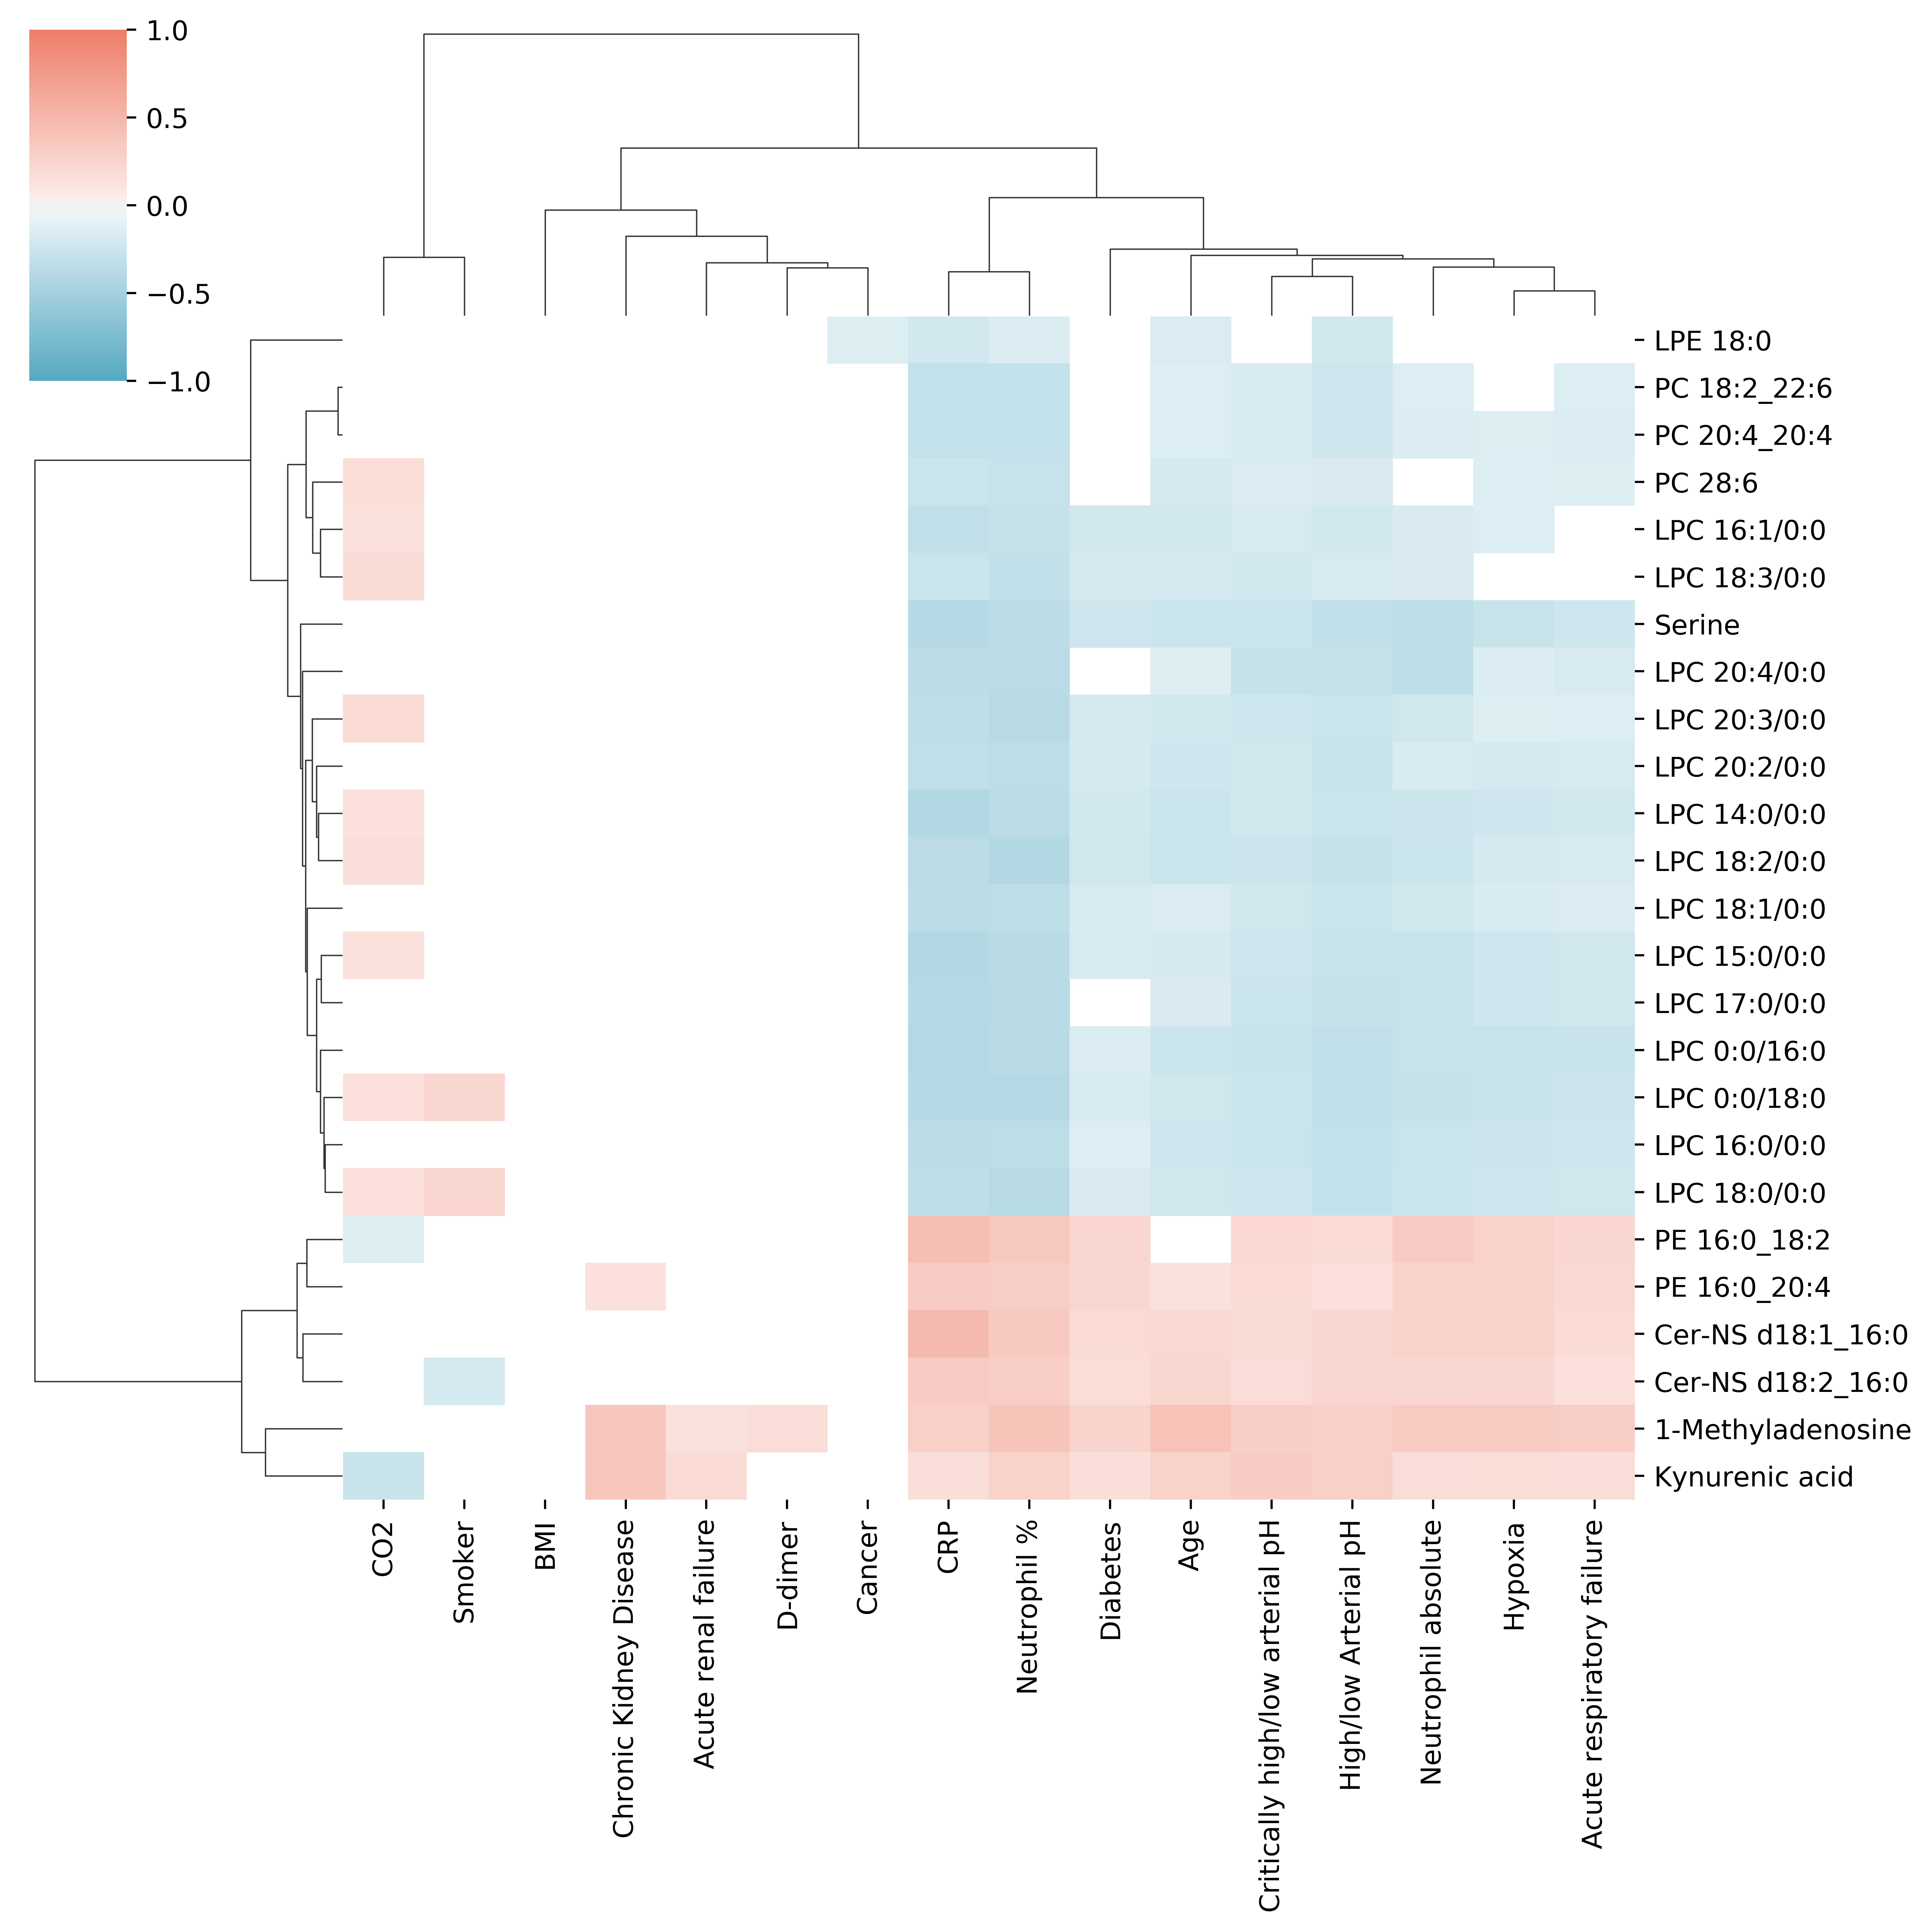

In [9]:
sb.clustermap(correlative_df,vmax=1.0,vmin=-1,cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True),mask=mask_df.astype(bool))


In [10]:
cross_corr_df = {}
cross_corr_pval = {}

for col in measurement_data.columns.values:
    cross_corr_df[col] = {}
    cross_corr_pval[col] = {}
    for col2 in measurement_data.columns.values:
        goodPat1 = []
        for pat in measurement_data.index.values:
            comorb = df.at[pat,col]
            if not pd.isna(comorb):
                if type(comorb) == type(""):
                    comorb = comorb.replace("<","").replace(">","")
                if float(comorb) > -.5:
                    goodPat1.append(pat)
        
        goodPat2 = []
        for pat in measurement_data.index.values:
            comorb = df.at[pat,col2]
            if not pd.isna(comorb):
                if type(comorb) == type(""):
                    comorb = comorb.replace("<","").replace(">","")
                if float(comorb) > -.5:
                    goodPat2.append(pat)
        
        goodPat = set(goodPat1).intersection(goodPat2)
        
        val1 = []
        val2 = []
        for pat in goodPat:
            v1 = measurement_data.at[pat,col]
            v2 = measurement_data.at[pat,col2]
            if type(v1) == type(""):
                v1 = v1.replace("<","").replace(">","")
            if type(v2) == type(""):
                v2 = v2.replace("<","").replace(">","")   
            val1.append(float(v1))
            val2.append(float(v2))

        r,p = stats.pearsonr(val1,val2)
        cross_corr_df[col][col2] = r
        cross_corr_pval[col][col2] = p

cross_corr_df = pd.DataFrame.from_dict(cross_corr_df,orient="index")
cross_corr_pval = pd.DataFrame.from_dict(cross_corr_pval,orient="index")

            





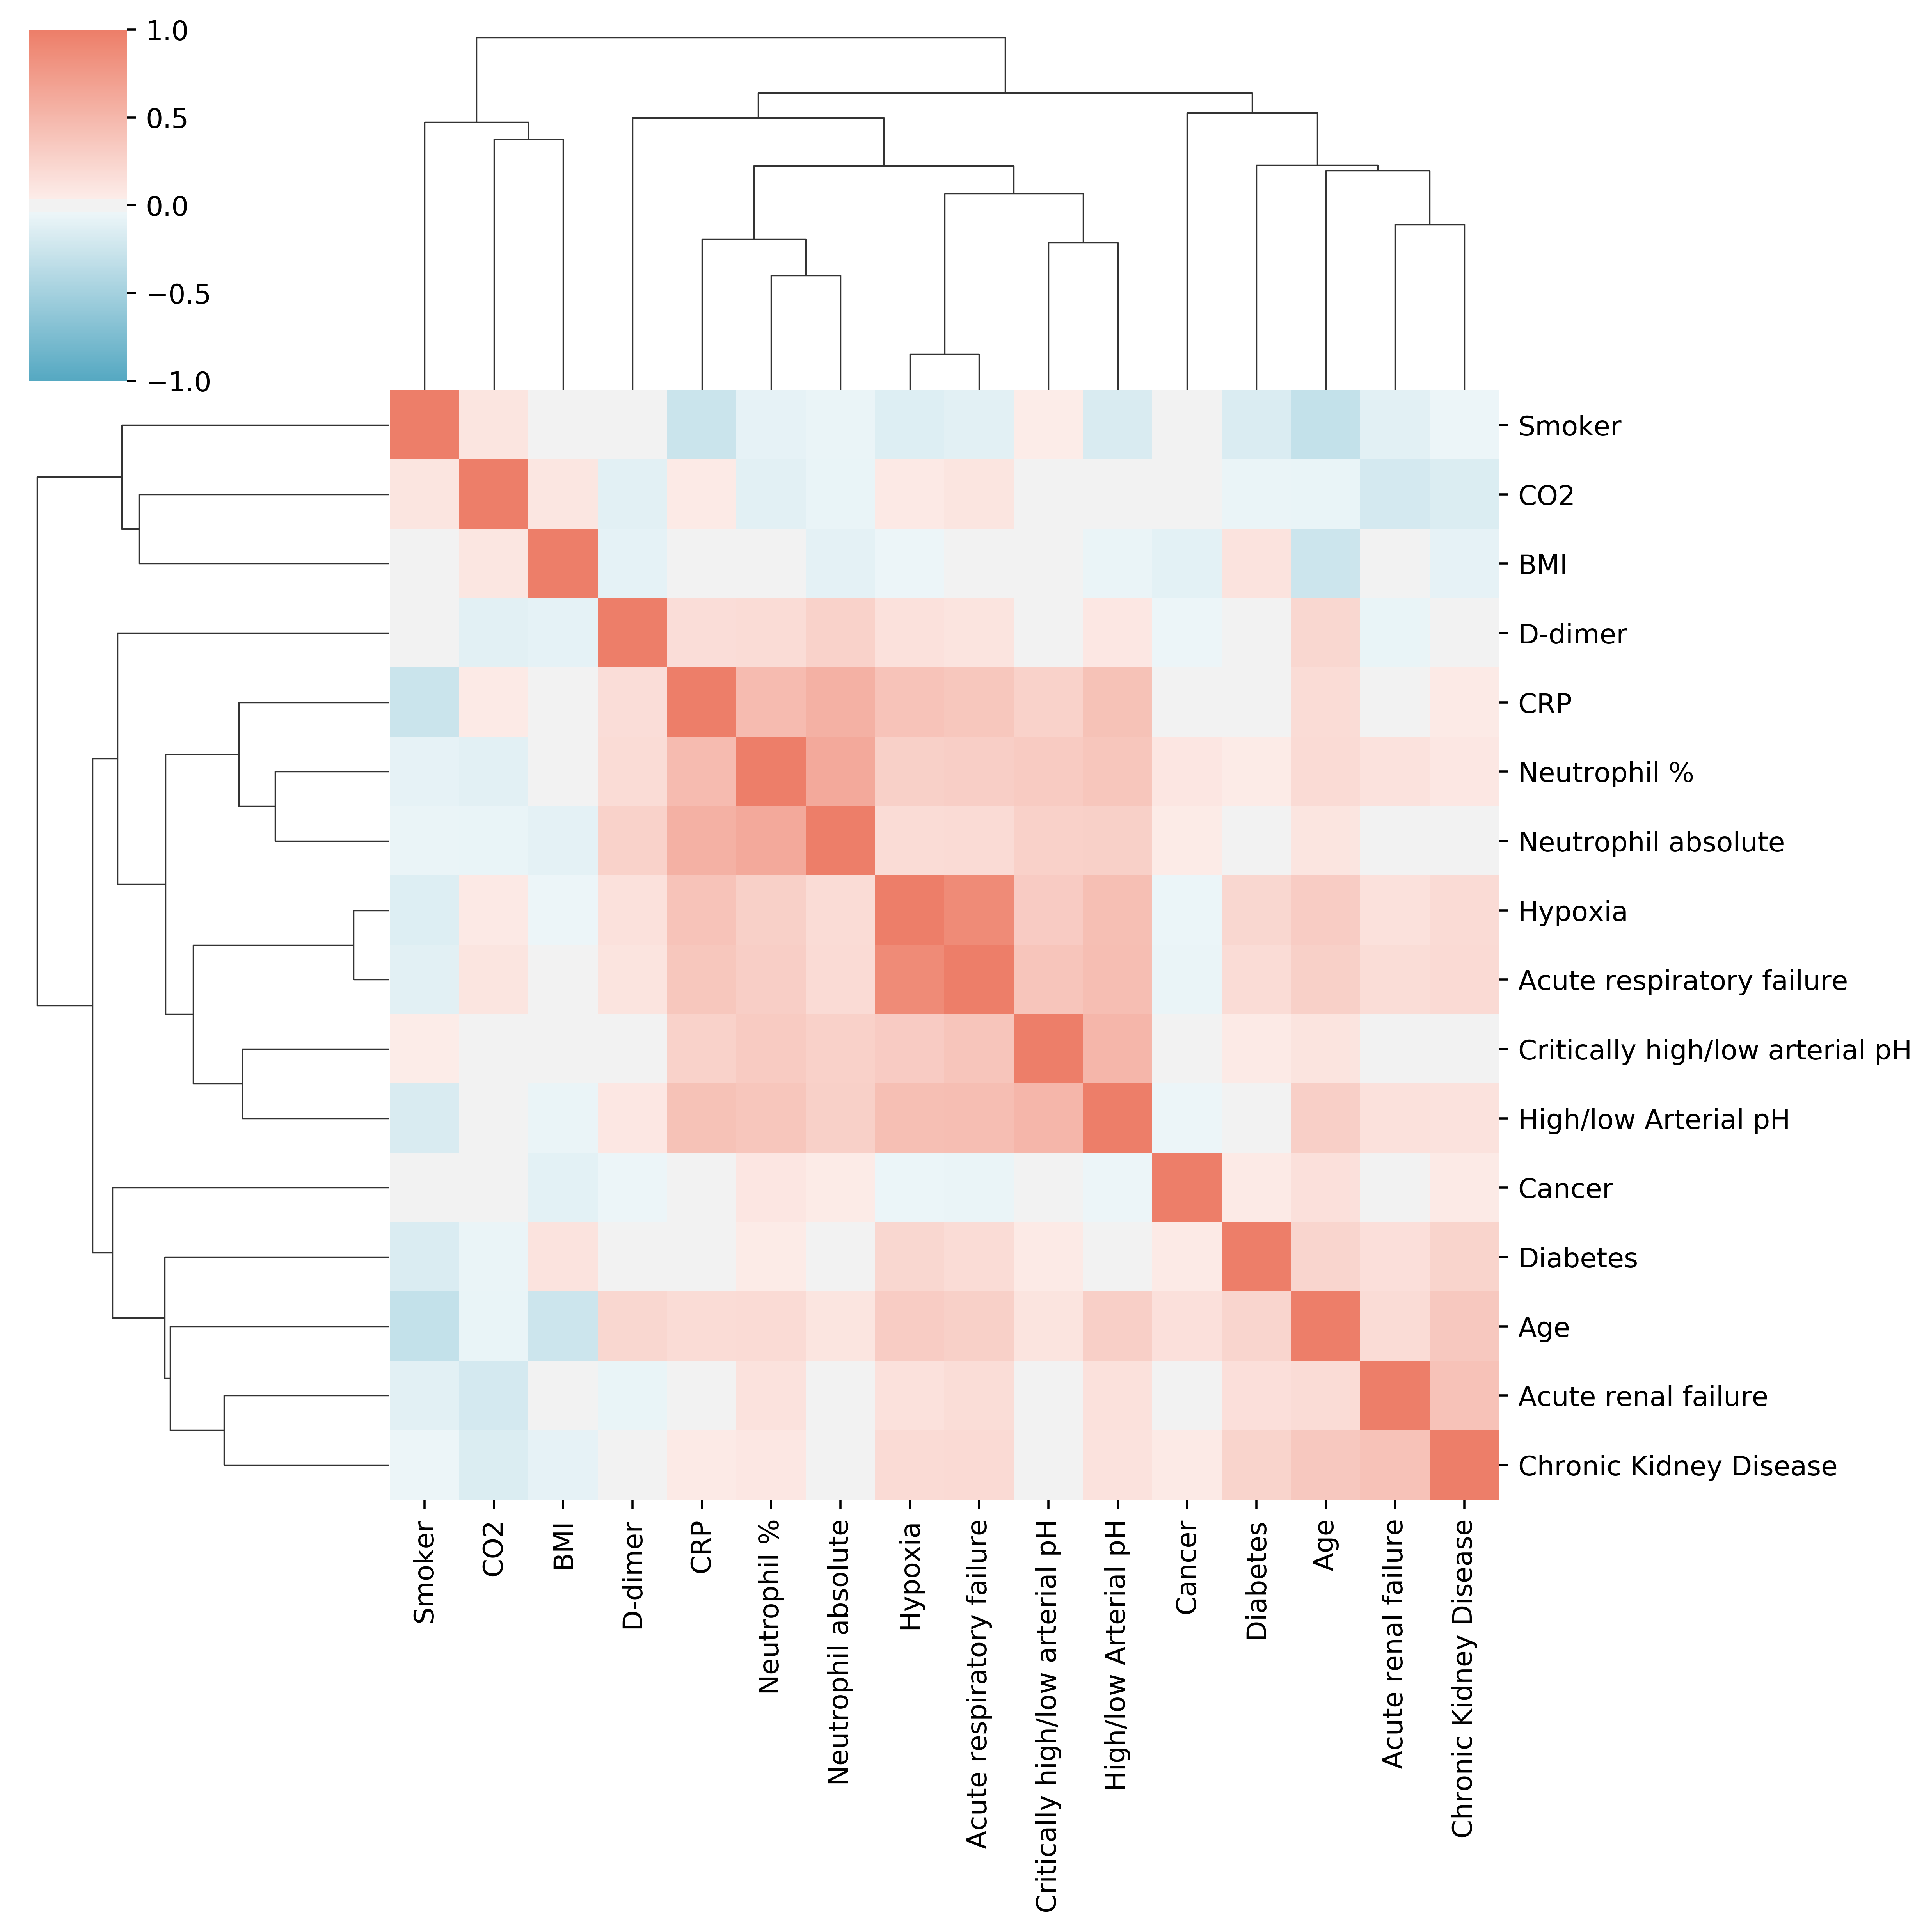

In [11]:
sb.clustermap(cross_corr_df,vmax = 1.0,vmin=-1.0,cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True),dendrogram_ratio=.25)

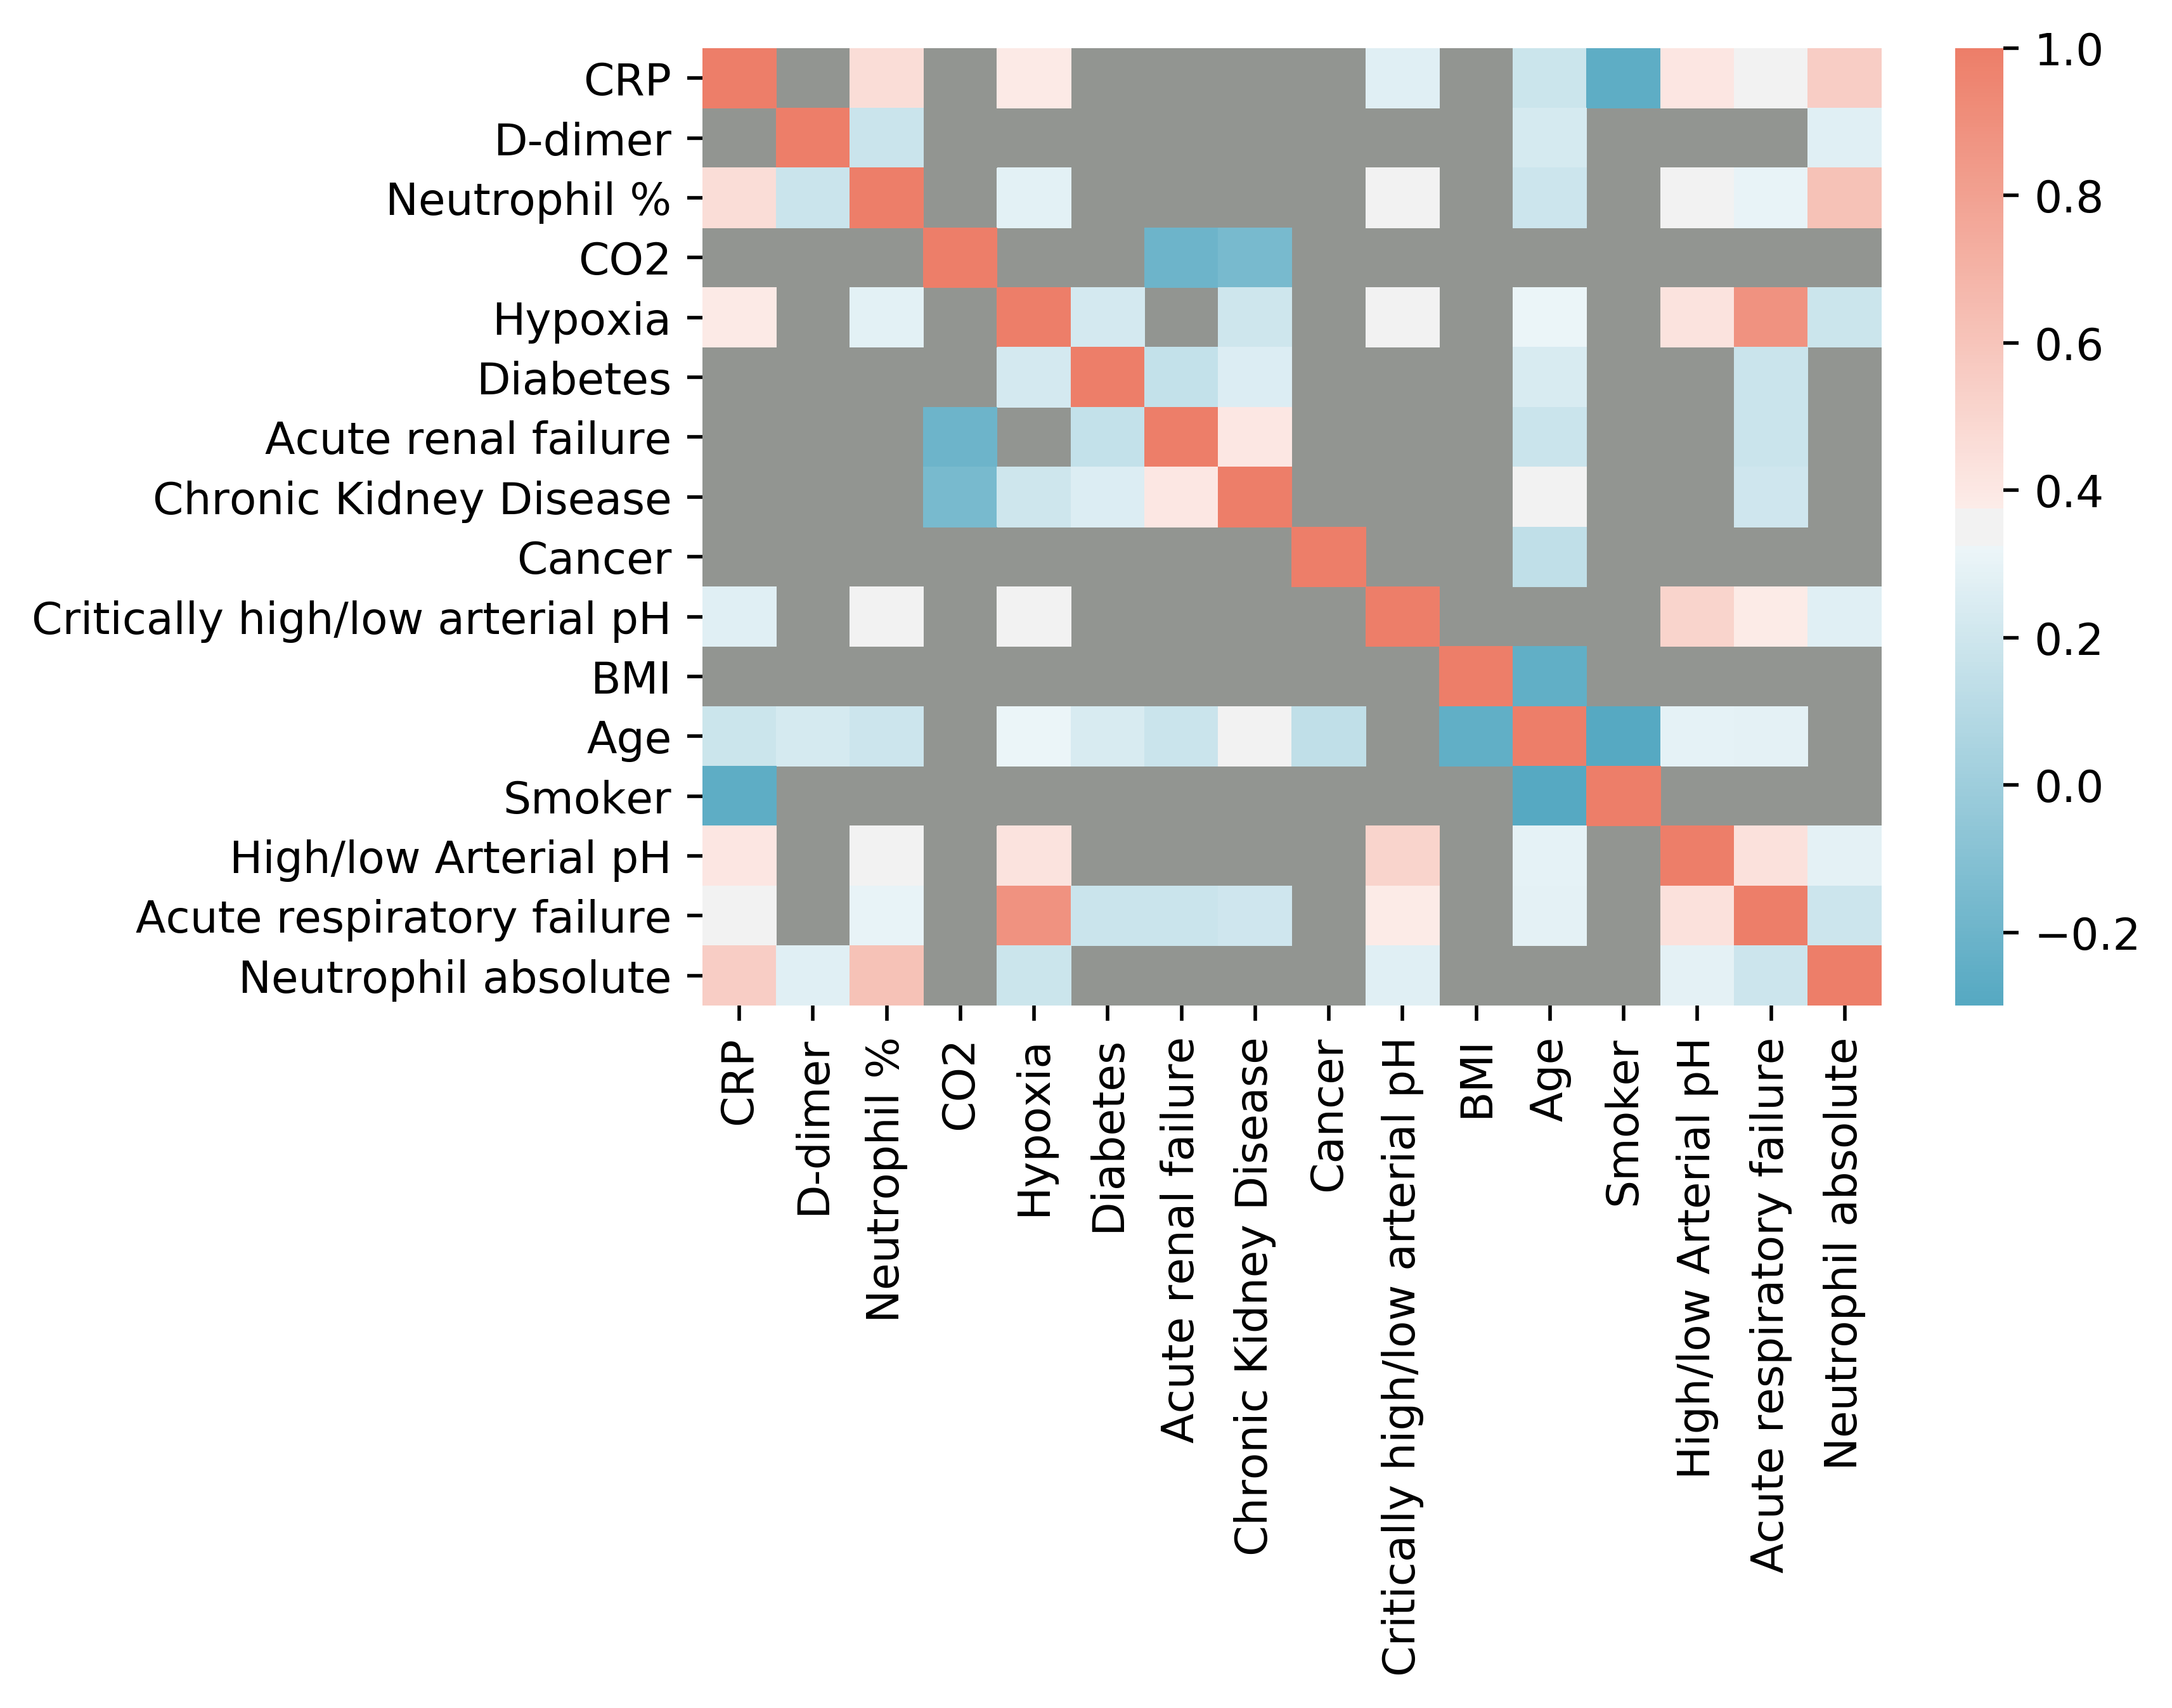

In [12]:
mask_df = deepcopy(cross_corr_pval)
ind = []
pvals = []
alpha = 0.05
for index,row in cross_corr_pval.iterrows():
    for col in cross_corr_pval.columns.values:
        ind.append((index,col))
        pvals.append(cross_corr_pval.at[index,col])

reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
for i,p in zip(ind,pvals_corr):
    if p < alpha:
        mask_df.at[i[0],i[1]] = 0
    else:
        mask_df.at[i[0],i[1]] = 1
        
p = sb.heatmap(cross_corr_df,mask=mask_df.astype(bool),cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True))
p.set_facecolor('xkcd:grey')
